# US Airline Ticket Prices (2018
## an exploration of price prediction
### Thomas Derrien

In [1]:
import time


from IPython.display import HTML

import os

import numpy as np

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import SVR
from sklearn.cluster import KMeans


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

import seaborn as sns
import matplotlib.pyplot as plt

import requests
import pandas as pd
import plotly.express as px

from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')


In [2]:


HTML('<iframe src="https://giphy.com/embed/U6dw1Tfu53rkJuVGXz" width="480" height="269" style="border:none;" frameBorder="0" allowFullScreen></iframe>')

In [3]:


df = pd.read_csv('data/cleaned_2018_flights.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9534417 entries, 0 to 9534416
Data columns (total 14 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Unnamed: 0         int64  
 1   ItinID             int64  
 2   MktID              int64  
 3   MktCoupons         int64  
 4   Quarter            int64  
 5   Origin             object 
 6   OriginWac          int64  
 7   Dest               object 
 8   DestWac            int64  
 9   Miles              float64
 10  ContiguousUSA      int64  
 11  NumTicketsOrdered  float64
 12  AirlineCompany     object 
 13  PricePerTicket     float64
dtypes: float64(3), int64(8), object(3)
memory usage: 1018.4+ MB


In [4]:
df.head()

Unnamed: 0       ItinID          MktID  MktCoupons  Quarter Origin  \
0           0  20181767585  2018176758501           1        1    PHL   
1           1  20181767586  2018176758601           1        1    PHL   
2           2  20181767587  2018176758701           1        1    PHL   
3           3  20181767636  2018176763601           1        1    PHL   
4           4  20181767637  2018176763701           1        1    PHL   

   OriginWac Dest  DestWac   Miles  ContiguousUSA  NumTicketsOrdered  \
0         23  LAX       91  2402.0              2                1.0   
1         23  LAX       91  2402.0              2                1.0   
2         23  LAX       91  2402.0              2                1.0   
3         23  LAX       91  2402.0              2                1.0   
4         23  LAX       91  2402.0              2                1.0   

  AirlineCompany  PricePerTicket  
0             AA          672.87  
1             AA          367.68  
2             AA          417.94  
3             AA          247.10  
4             AA          276.35

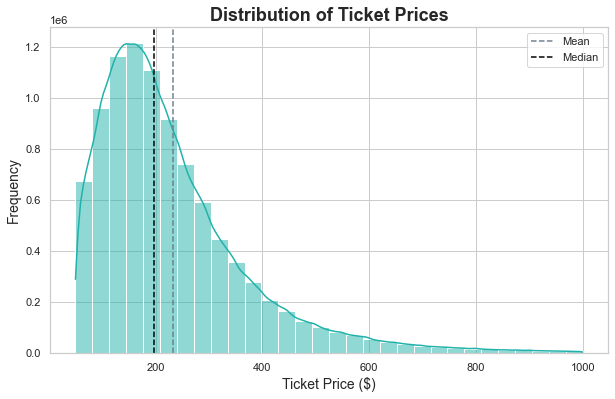

In [5]:


plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")
sns.histplot(data=df, x='PricePerTicket', kde=True, color='lightseagreen', bins=30)
plt.axvline(df['PricePerTicket'].mean(), color='slategrey', linestyle='--', label='Mean')
plt.axvline(df['PricePerTicket'].median(), color='black', linestyle='--', label='Median')
plt.legend()
plt.title('Distribution of Ticket Prices', fontsize=18, fontweight='bold')
plt.xlabel('Ticket Price ($)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

In [6]:
#Dictionaries to improve labelling
companies = {
    "WN": "Southwest Airlines Co.",
    "DL": "Delta Air Lines Inc.",
    "AA": "American Airlines Inc.",
    "UA": "United Air Lines Inc.",
    "B6": "JetBlue Airways",
    "AS": "Alaska Airlines Inc.",
    "NK": "Spirit Air Lines",
    "G4": "Allegiant Air",
    "F9": "Frontier Airlines Inc.",
    "HA": "Hawaiian Airlines Inc.",
    "SY": "Sun Country Airlines",
    "VX": "Virgin America"
}

states = {
    1: "Alaska",
    2: "Hawaii",
    3: "Puerto Rico",
    4: "U.S. Virgin Islands",
    5: "U.S. Pacific Trust Territories and Possessions",
    11: "Connecticut",
    12: "Maine",
    13: "Massachusetts",
    14: "New Hampshire",
    15: "Rhode Island",
    16: "Vermont",
    21: "New Jersey",
    22: "New York",
    23: "Pennsylvania",
    31: "Delaware",
    32: "District of Columbia",
    33: "Florida",
    34: "Georgia",
    35: "Maryland",
    36: "North Carolina",
    37: "South Carolina",
    38: "Virginia",
    39: "West Virginia",
    41: "Illinois",
    42: "Indiana",
    43: "Michigan",
    44: "Ohio",
    45: "Wisconsin",
    51: "Alabama",
    52: "Kentucky",
    53: "Mississippi",
    54: "Tennessee",
    61: "Iowa",
    62: "Kansas",
    63: "Minnesota",
    64: "Missouri",
    65: "Nebraska",
    66: "North Dakota",
    67: "South Dakota",
    71: "Arkansas",
    72: "Louisiana",
    73: "Oklahoma",
    74: "Texas",
    81: "Arizona",
    82: "Colorado",
    83: "Idaho",
    84: "Montana",
    85: "Nevada",
    86: "New Mexico",
    87: "Utah",
    88: "Wyoming",
    91: "California",
    92: "Oregon",
    93: "Washington"
}

In [7]:
# Map airline codes to full names
df['AirlineName'] = df['AirlineCompany'].map(companies)
df['OriginState'] = df['OriginWac'].map(states)
df['DestState'] = df['DestWac'].map(states)

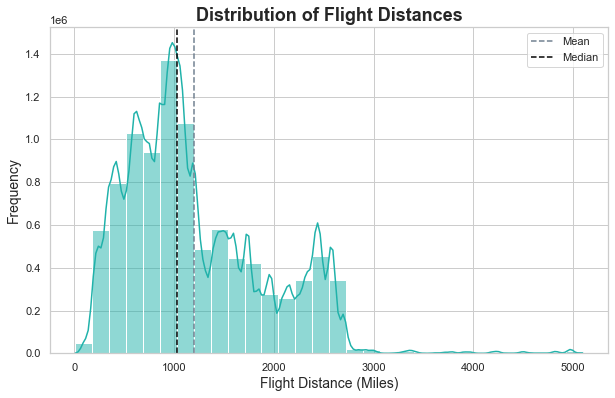

In [8]:
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")
sns.histplot(data=df, x='Miles', kde=True, color='lightseagreen', bins=30)
plt.axvline(df['Miles'].mean(), color='slategrey', linestyle='--', label='Mean')
plt.axvline(df['Miles'].median(), color='black', linestyle='--', label='Median')
plt.legend()
plt.title('Distribution of Flight Distances', fontsize=18, fontweight='bold')
plt.xlabel('Flight Distance (Miles)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

# Large positive skew still present wen split by airline company

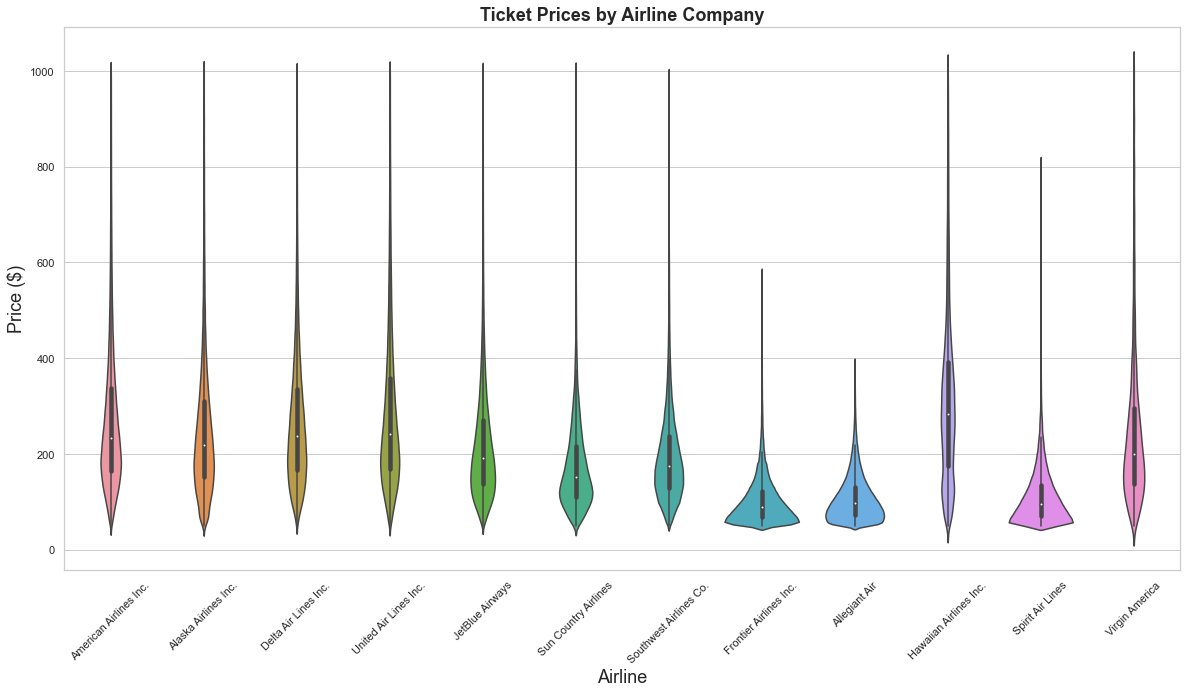

In [9]:
plt.figure(figsize=(20, 10))

sns.violinplot(x ="AirlineName", y ="PricePerTicket", data = df)
plt.title('Ticket Prices by Airline Company', fontsize=18, fontweight='bold')
plt.xlabel('Airline', fontsize=18)
plt.xticks(rotation=45)
plt.ylabel('Price ($)', fontsize=18)
plt.show()

# Negligible variation in price per quarter

Text(0, 0.5, 'Price')

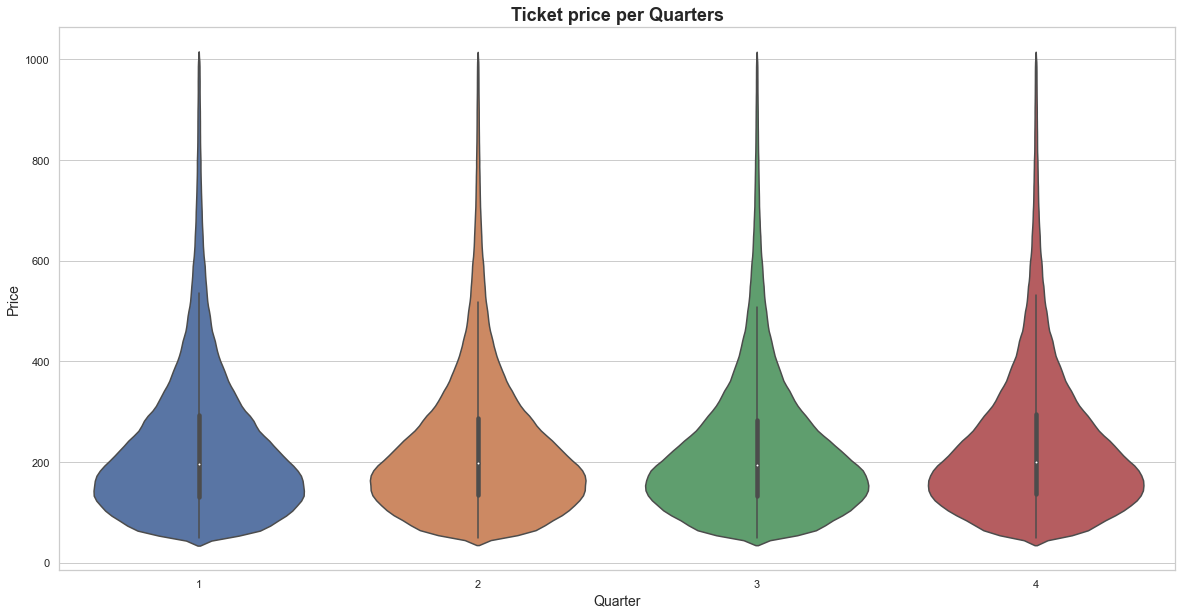

In [10]:
plt.figure(figsize=(20, 10))

sns.violinplot(x ="Quarter", y ="PricePerTicket", data = df)
plt.title('Ticket price per Quarters', fontsize=18, fontweight='bold')
plt.xlabel('Quarter', fontsize=14)
plt.ylabel('Price', fontsize=14)

# unsurprisingly, most ticket orders were only single orders, but a large amount were fro 2-5 tickets per order

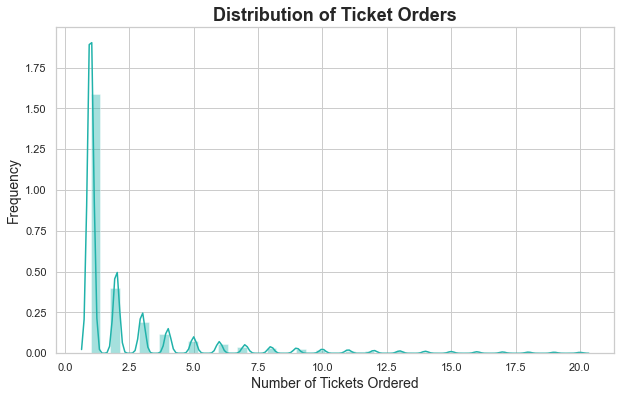

In [11]:
plt.figure(figsize=(10, 6))
sns.distplot(df['NumTicketsOrdered'], color='lightseagreen')
plt.title('Distribution of Ticket Orders', fontsize=18, fontweight='bold')
plt.xlabel('Number of Tickets Ordered', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

# heatmap of price vs miles shows clusters, could indicate clustering as valid mehtod for price prediction

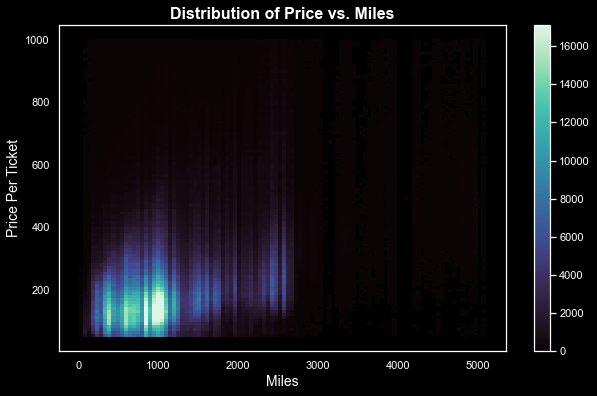

In [12]:
#sns.set_theme(style="darkgrid")
plt.style.use('dark_background')
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Miles', y='PricePerTicket', bins=100, pmax=0.95, cmap='mako', cbar=True, vmin=0)
plt.title('Distribution of Price vs. Miles', fontsize=16, fontweight='bold')
plt.xlabel('Miles', fontsize=14)
plt.ylabel('Price Per Ticket', fontsize=14)
plt.grid(False
        )
plt.show()
#possible to fill whitespace? do i need to add dummy data to df? 

In [13]:
#control for positive skew by adding logPrice column
df['LogPrice'] = np.log1p(df['PricePerTicket'])

# log distribution is symmetric, as expected for skewed data

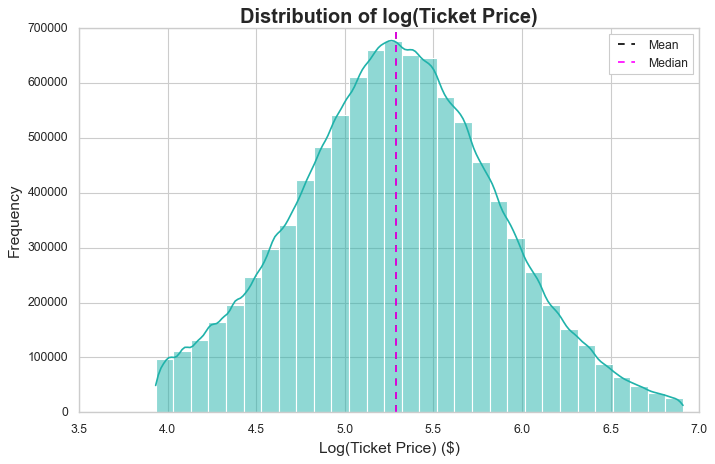

In [14]:
plt.style.use('classic')
sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6))

sns.histplot(data=df, x='LogPrice', kde=True, color='lightseagreen', bins=30)
plt.axvline(df['LogPrice'].mean(), color='black', linestyle='--', label='Mean')
plt.axvline(df['LogPrice'].median(), color='fuchsia', linestyle='--', label='Median')
plt.legend()
plt.title('Distribution of log(Ticket Price)', fontsize=18, fontweight='bold')
plt.xlabel('Log(Ticket Price) ($)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

# Visualisation of origins and desitinations
## Top 3 origins, destination are the same CA, FL, and TX

In [15]:


# json mess to get
url = "https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json"
usmap = requests.get(url).json()  # Directly parse JSON



# count origin/dest, reset index is the key!
origin_counts = df['OriginState'].value_counts().reset_index()
origin_counts.columns = ['State', 'OriginCount']

dest_counts = df['DestState'].value_counts().reset_index()
dest_counts.columns = ['State', 'DestCount']

# combine both counts with states is it outer? 
state_counts = pd.merge(origin_counts, dest_counts, on='State', how='outer')

state_counts


State  OriginCount  DestCount
0                                       California      1329715    1328001
1                                          Florida      1128347    1135413
2                                            Texas       814388     816505
3                                         New York       520623     517409
4                                         Illinois       463528     454707
5                                          Georgia       427349     433156
6                                         Colorado       384168     382836
7                                       Washington       324123     324974
8                                           Nevada       318175     315251
9                                    Massachusetts       298941     300008
10                                         Arizona       281606     281050
11                                      New Jersey       264478     264435
12                                        Virginia       262658     264090
13                                    Pennsylvania       231690     232188
14                                       Minnesota       223499     223025
15                                  North Carolina       222789     215194
16                                        Michigan       195643     193519
17                                          Hawaii       179548     185978
18                                        Missouri       178085     180996
19                                        Maryland       169837     170387
20                                            Utah       140595     140873
21                                          Oregon       139212     139995
22                                       Tennessee       138249     137636
23                                       Louisiana       122178     122549
24                                            Ohio       120550     120470
25                                        Kentucky        73216      70411
26                                         Indiana        65265      64537
27                                       Wisconsin        59295      59409
28                                     Puerto Rico        52810      53314
29                                          Alaska        51796      52460
30                                     Connecticut        48943      49364
31                                  South Carolina        47900      48487
32                                        Oklahoma        32487      32528
33                                      New Mexico        31375      32126
34                                        Nebraska        30670      30760
35                                    Rhode Island        26626      27009
36                                           Idaho        18463      18103
37                                            Iowa        18038      18177
38                                         Montana        16739      17155
39                                         Alabama        10372       9888
40                                           Maine        10059      10296
41                                   New Hampshire         9890       9989
42                                        Arkansas         9690       9365
43                                    North Dakota         8542       8401
44                             U.S. Virgin Islands         7268       7368
45                                          Kansas         6660       6541
46                                    South Dakota         5720       5700
47                                         Vermont         3270       3437
48                                         Wyoming         2932       3054
49                                     Mississippi         2802       2435
50                                   West Virginia         2551       2394
51  U.S. Pacific Trust Territories and Possessions         1064       1064

In [16]:
# origin plots
fig = px.choropleth(
    state_counts,
    geojson=usmap,  
    locations="State",  
    featureidkey="properties.name",  
    color="OriginCount", 
    color_continuous_scale="Oranges",
    title="Number of Flights by Origin State"
)
fig.update_geos(fitbounds="locations")
fig.show()



In [17]:
# dest~ plost
fig = px.choropleth(
    state_counts,
    geojson=usmap,  
    locations="State",  
    featureidkey="properties.name",  
    color="DestCount", 
    color_continuous_scale="Blues",
    title="Number of Flights by Destination State"
)
fig.update_geos(fitbounds="locations")
fig.show()

# Model Comparison

# Tesing various machine learning models for price prediction
## 1) Random forest

### Using original data, all variables

In [18]:


t0 = time.time()

#no need to encode if use WAC for origin and Dest!
X = df[['Miles', 'Quarter', 'Origin', 'Dest', 'ContiguousUSA', 'AirlineCompany', 'NumTicketsOrdered']]  # add/remove


X['Dest'] = OrdinalEncoder().fit_transform(X[['Dest']])
X['Origin'] = OrdinalEncoder().fit_transform(X[['Origin']])
X['AirlineCompany'] = OrdinalEncoder().fit_transform(X[['AirlineCompany']])


y = df['PricePerTicket']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

rf_predictions = rf_model.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_predictions)
print("Mean Squared Error:", rf_mse)
t1 = time.time()

total_time = (t1-t0)/60
print('Code took', round(total_time, 2), 'minutes')

Mean Squared Error: 13877.840393805564
Code took 31.67 minutes


In [19]:




print('The approximate RMSE in the price prediction is: $', round(np.sqrt(rf_mse), 2))

The approximate RMSE in the price prediction is: $ 117.8


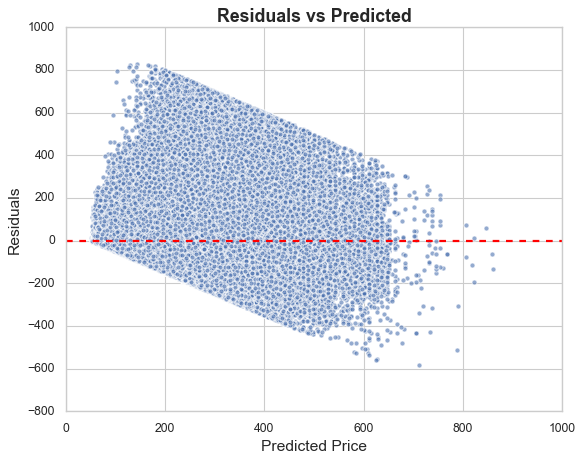

In [20]:

rf_residuals = y_test - rf_predictions


plt.figure(figsize=(8, 6))
plt.scatter(rf_predictions, rf_residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title('Residuals vs Predicted', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Price', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.show()

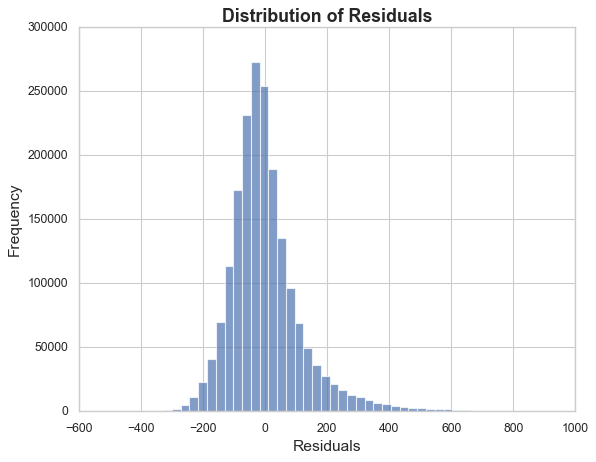

In [21]:
plt.figure(figsize=(8, 6))
plt.hist(rf_residuals, bins=50, alpha=0.7)
plt.title('Distribution of Residuals', fontsize=16, fontweight='bold')
plt.xlabel('Residuals', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

Text(0, 0.5, 'Importance')

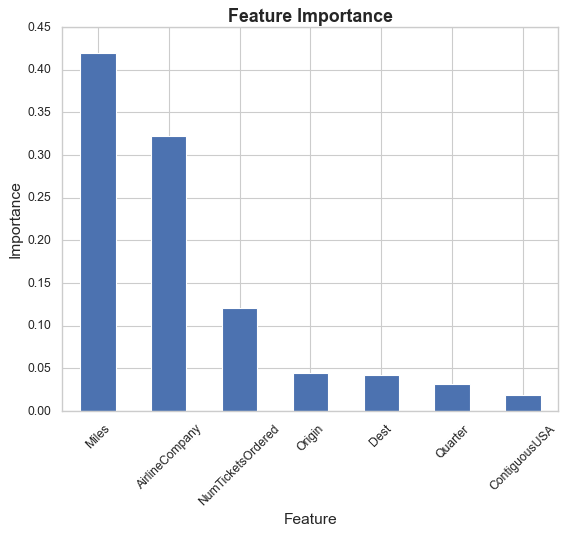

In [22]:
(pd.Series(rf_model.feature_importances_, index=X.columns)
   .sort_values(ascending=False)
   .plot(kind='bar'))
plt.title('Feature Importance', fontsize=16, fontweight='bold')
plt.xlabel('Feature', fontsize=14)
plt.xticks(rotation=45)
plt.ylabel('Importance', fontsize=14)

# xgboost


In [23]:


t0 = time.time()


# prepe data
X = df[['Miles', 'Quarter', 'OriginWac', 'DestWac', 'ContiguousUSA', 'AirlineCompany', 'NumTicketsOrdered', 'MktCoupons']]  # add/remove
X['AirlineCompany'] = OrdinalEncoder().fit_transform(X[['AirlineCompany']])

y = df['PricePerTicket']
#traintestsplit
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#traintestsplit
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#train
xgb_model = XGBRegressor(
    n_estimators=100,    # tree number
    learning_rate=0.1,   #google: The learning rate, also known in R as shrinkage, 
    #contribution of each tree to final result and controls how fast the algorithm will drive 
    #toward the minimum gradient value.
    max_depth=6,         # tree depth
    subsample=0.8,       # feature/tree for traiing?
    colsample_bytree=0.8, # feature/tree
    random_state=42
)
xgb_model.fit(X_train, y_train)

#rpedict
xgb_predictions = xgb_model.predict(X_test)
xgb_mse = mean_squared_error(y_test, xgb_predictions)
print("Mean Squared Error:", xgb_mse)
t1 = time.time()

total_time = (t1-t0)/60
print('Code took', round(total_time, 2), 'minutes')

Mean Squared Error: 14328.709167416186
Code took 0.59 minutes


In [24]:
print('The approximate RMSE in the price prediction is: $', round(np.sqrt(xgb_mse), 2))

The approximate RMSE in the price prediction is: $ 119.7


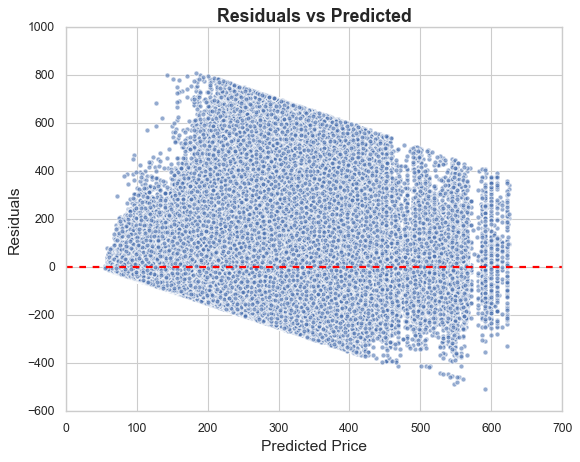

In [25]:
xgb_residuals = y_test - xgb_predictions

plt.figure(figsize=(8, 6))
plt.scatter(xgb_predictions, xgb_residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title('Residuals vs Predicted', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Price', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.show()

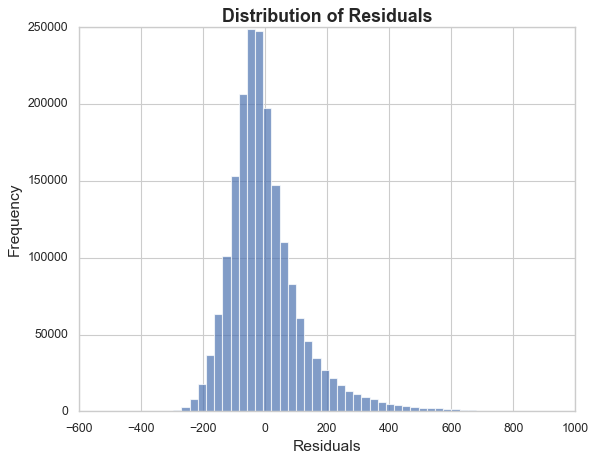

In [26]:
plt.figure(figsize=(8, 6))
plt.hist(xgb_residuals, bins=50, alpha=0.7)
plt.title('Distribution of Residuals', fontsize=16, fontweight='bold')
plt.xlabel('Residuals', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

Text(0, 0.5, 'Importance')

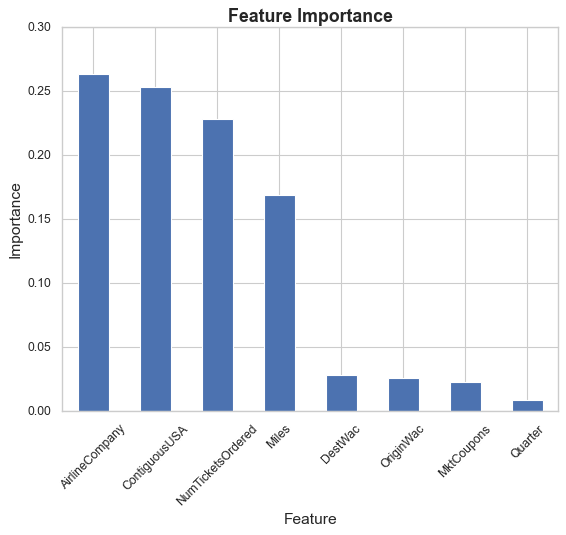

In [27]:
(pd.Series(xgb_model.feature_importances_, index=X.columns)
 .sort_values(ascending=False)
   .plot(kind='bar'))
plt.title('Feature Importance', fontsize=16, fontweight='bold')
plt.xlabel('Feature', fontsize=14)
plt.xticks(rotation=45)
plt.ylabel('Importance', fontsize=14)

## SVR
too long to run on normal PC! sample 100 000 entries as example 5.5 min, how long 1 000 000?

In [28]:
#sample from df
df_sample = df.sample(n=100000, random_state=42)

In [29]:


t0 = time.time()



# prepe data
X = df_sample[['Miles', 'Quarter', 'OriginWac', 'DestWac', 'ContiguousUSA', 'AirlineCompany', 'NumTicketsOrdered', 'MktCoupons']]  # add/remove
X['AirlineCompany'] = OrdinalEncoder().fit_transform(X[['AirlineCompany']])

y = df_sample['PricePerTicket']
#traintestsplit
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# need to scale?
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# train
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)  # linear kernel may be quick
svr_model.fit(X_train_scaled, y_train)

# predict
y_pred_svr = svr_model.predict(X_test_scaled)

# eval
mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)
print(f"SVR MSE: {mse_svr}")
print(f"SVR R²: {r2_svr}")

t1 = time.time()
total_time = (t1-t0)/60
print('Code took', round(total_time, 2), 'minutes')

SVR MSE: 17790.009880121874
SVR R²: 0.12437726956868878
Code took 5.77 minutes


In [30]:
print('The approximate RMSE in the price prediction is: $', round(np.sqrt(mse_svr), 2))

The approximate RMSE in the price prediction is: $ 133.38


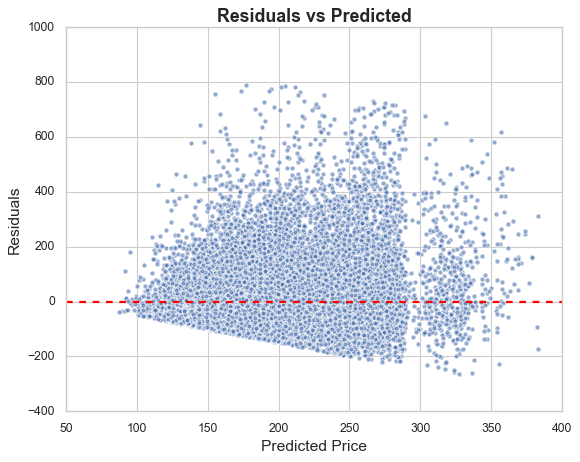

In [31]:
svr_residuals = y_test - y_pred_svr

plt.figure(figsize=(8, 6))
plt.scatter(y_pred_svr, svr_residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title('Residuals vs Predicted', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Price', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.show()

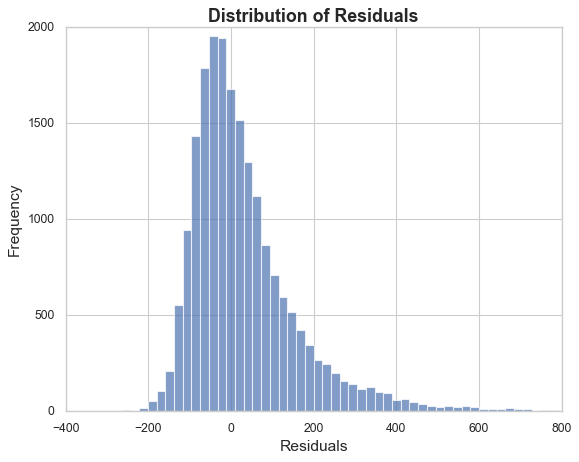

In [32]:
plt.figure(figsize=(8, 6))
plt.hist(svr_residuals, bins=50, alpha=0.7)
plt.title('Distribution of Residuals', fontsize=16, fontweight='bold')
plt.xlabel('Residuals', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

no feature importance with SVR

# clustering xgb
## random forest regressor better than the xgboost but much slower, clustering involves running 4x, so will run as xgboost

In [33]:

t0 = time.time()

#select featyres
X = df[['Miles', 'Quarter', 'Origin', 'Dest', 'ContiguousUSA', 'DestWac', 'AirlineCompany', 'MktCoupons', 'NumTicketsOrdered']]
y = df['PricePerTicket']  # Ensure 'Price' aligns with filtered_df

# align x y
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)


X['Dest'] = OrdinalEncoder().fit_transform(X[['Dest']])
X['Origin'] = OrdinalEncoder().fit_transform(X[['Origin']])
X['AirlineCompany'] = OrdinalEncoder().fit_transform(X[['AirlineCompany']])

#can make more efficient:
#X[['Dest', 'Origin', 'AirlineCompany']] = OrdinalEncoder().fit_transform(X[['Dest', 'Origin', 'AirlineCompany']])

# k-means clustering- needc to test indivudal clusters for model
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
X['Cluster'] = kmeans.fit_predict(X)

#tts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train each cluster
km_models = {}
for cluster in range(n_clusters):
    cluster_indices = X_train['Cluster'] == cluster
    X_cluster_train = X_train[cluster_indices].drop(columns=['Cluster'])
    y_cluster_train = y_train[cluster_indices]
    
    km_model = XGBRegressor(
    n_estimators=100,    
    learning_rate=0.1,   
    max_depth=6,         
    subsample=0.8,       
    colsample_bytree=0.8, 
    random_state=42
)
    km_model.fit(X_cluster_train, y_cluster_train)
    km_models[cluster] = km_model

# cluster prdict
X_test_clusters = X_test.copy()
X_test_clusters['Cluster'] = kmeans.predict(X_test_clusters.drop(columns=['Cluster']))
all_predictions = []  
for i in range(len(X_test)):
    cluster = X_test_clusters.iloc[i]['Cluster']
    km_model = km_models[cluster]
    km_prediction = km_model.predict([X_test_clusters.iloc[i].drop('Cluster')])  # Predict for the instance
    all_predictions.append(km_prediction[0])

# spit out goodness
km_mse = mean_squared_error(y_test, all_predictions)
print("Mean Squared Error:", )
print("Root mean Squared Error:", np.sqrt(km_mse))

t1 = time.time()

total_time = (t1-t0)/60
print('Code took', round(total_time, 2), 'minutes')

Mean Squared Error:
Root mean Squared Error: 118.19432414567032
Code took 57.27 minutes


In [34]:
print('The approximate RMSE in the price prediction is: $', round(np.sqrt(km_mse), 2))

The approximate RMSE in the price prediction is: $ 118.19


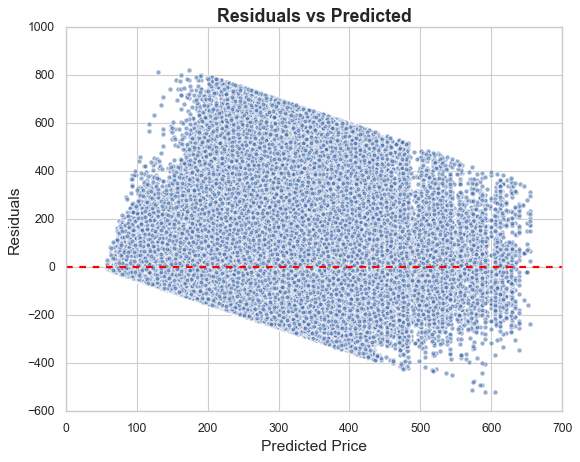

In [35]:
km_residuals = y_test - all_predictions

plt.figure(figsize=(8, 6))
plt.scatter(all_predictions, km_residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title('Residuals vs Predicted', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Price', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.show()

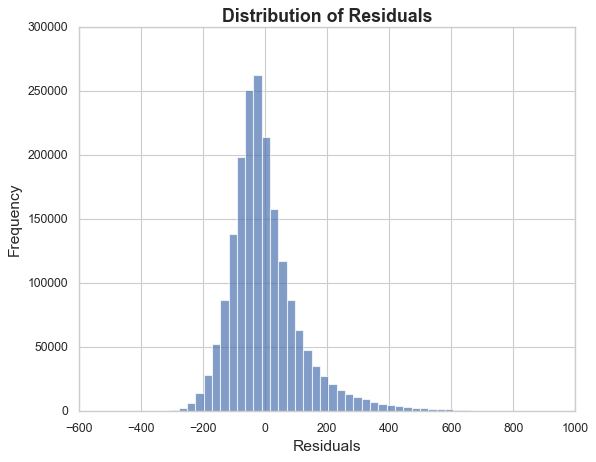

In [36]:
plt.figure(figsize=(8, 6))
plt.hist(km_residuals, bins=50, alpha=0.7)
plt.title('Distribution of Residuals', fontsize=16, fontweight='bold')
plt.xlabel('Residuals', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

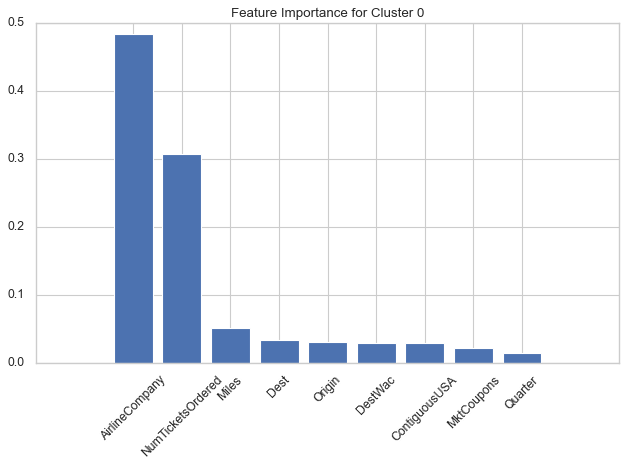

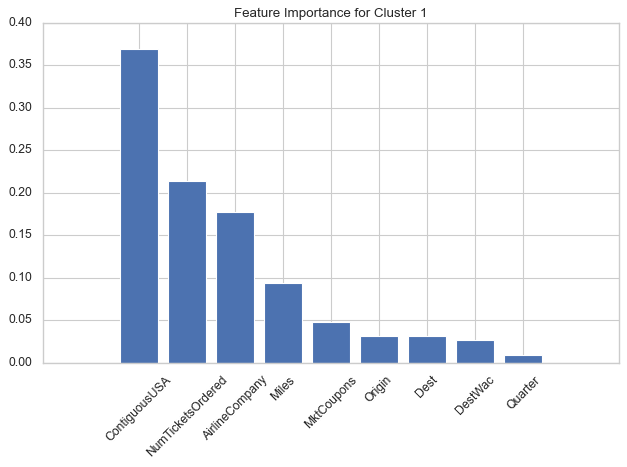

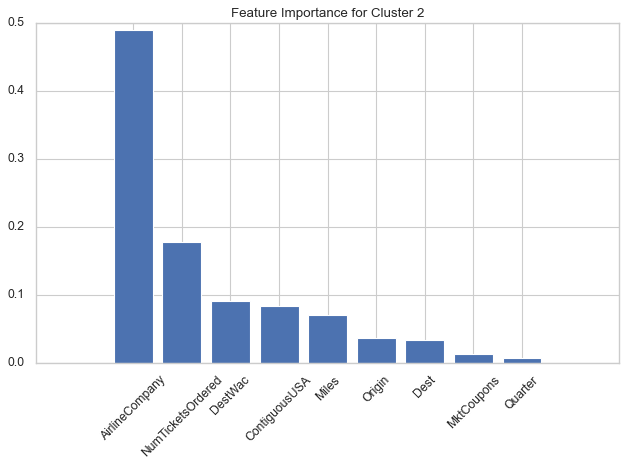

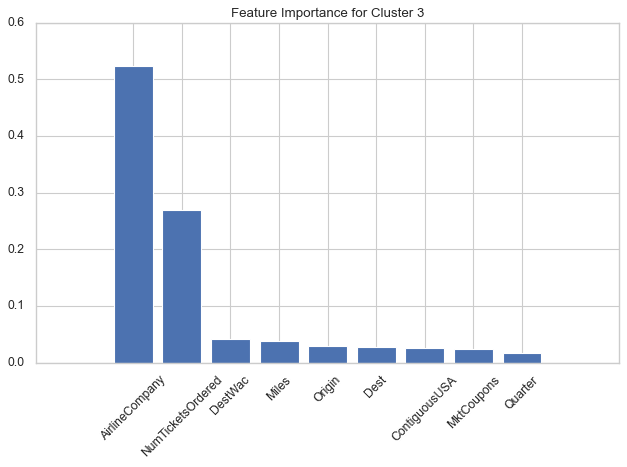

In [37]:
for cluster, km_model in km_models.items():
    km_importances = km_model.feature_importances_
    feature_names = X_train.drop(columns=['Cluster']).columns
    indices = np.argsort(km_importances)[::-1]  # Sort by importance

    plt.figure(figsize=(8, 6))
    plt.title(f"Feature Importance for Cluster {cluster}")
    plt.bar(range(len(km_importances)), km_importances[indices], align="center")
    plt.xticks(range(len(km_importances)), feature_names[indices], rotation=45)
    plt.tight_layout()
    plt.show()

# Improve by log transform and outlier fitler
## suspect outliers causing inacurracy
filter outliers based on origin
rety model

# Cleaning data based outlier, computing IQR for each origin and removing
## results in removal of 432472 values

In [38]:

def outlier_filter(group, price_column):

    Q1 = group[price_column].quantile(0.25)
    Q3 = group[price_column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    return group[(group[price_column] >= lower_bound) & (group[price_column] <= upper_bound)]

def origin_filter(df, price_column='PricePerTicket', origin_column='Origin'):

    
    return df.groupby(origin_column, group_keys=False).apply(outlier_filter, price_column=price_column)

In [39]:
filtered_df = origin_filter(df, price_column='PricePerTicket', origin_column='Origin')
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9101945 entries, 676132 to 1375908
Data columns (total 18 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Unnamed: 0         int64  
 1   ItinID             int64  
 2   MktID              int64  
 3   MktCoupons         int64  
 4   Quarter            int64  
 5   Origin             object 
 6   OriginWac          int64  
 7   Dest               object 
 8   DestWac            int64  
 9   Miles              float64
 10  ContiguousUSA      int64  
 11  NumTicketsOrdered  float64
 12  AirlineCompany     object 
 13  PricePerTicket     float64
 14  AirlineName        object 
 15  OriginState        object 
 16  DestState          object 
 17  LogPrice           float64
dtypes: float64(4), int64(8), object(6)
memory usage: 1.3+ GB


In [40]:
#add log price series
filtered_df['LogPrice'] = np.log1p(filtered_df['PricePerTicket'])

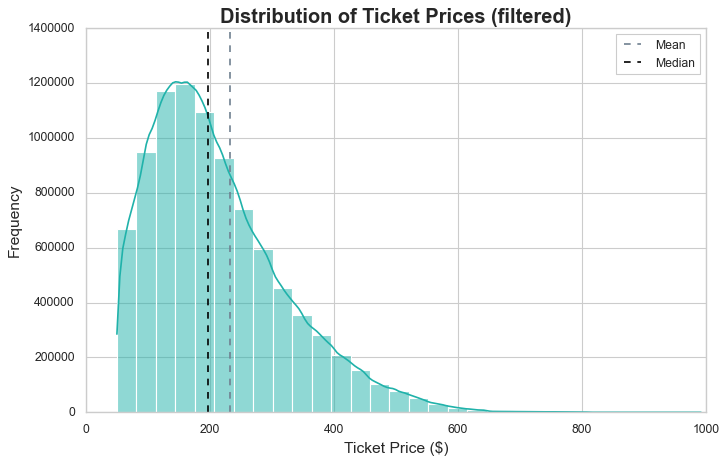

In [41]:

plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")
sns.histplot(data=filtered_df, x='PricePerTicket', kde=True, color='lightseagreen', bins=30)
plt.axvline(df['PricePerTicket'].mean(), color='slategrey', linestyle='--', label='Mean')
plt.axvline(df['PricePerTicket'].median(), color='black', linestyle='--', label='Median')
plt.legend()
plt.title('Distribution of Ticket Prices (filtered)', fontsize=18, fontweight='bold')
plt.xlabel('Ticket Price ($)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

# heavy positive skew

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

X = filtered_df[['Miles', 'Quarter', 'OriginWac', 'ContiguousUSA', 'DestWac', 'AirlineCompany', 'NumTicketsOrdered']]  # add/remove

X['AirlineCompany'] = OrdinalEncoder().fit_transform(X[['AirlineCompany']])


y = filtered_df['LogPrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rflog_model = RandomForestRegressor()
rflog_model.fit(X_train, y_train)

rflog_predictions = rflog_model.predict(X_test)
print("Mean Squared Error:", mean_squared_error(y_test, rflog_predictions))

Mean Squared Error: 0.1663367828318392


In [46]:
rflog_mse = mean_squared_error(y_test, rflog_predictions)

In [48]:
#logrmse
rmse_rflog = np.sqrt(rflog_mse)

# proption error
rmse_original_proportion = np.exp(rmse_rflog) - 1

# holla in the dolla
mean_price = df['PricePerTicket'].mean()
rmse_original_dollars = mean_price * rmse_original_proportion

print("Approximate RMSE in price prediction (dollars): $", round(rmse_original_dollars, 2))

Approximate RMSE in price prediction (dollars): $ 117.06


# xgboost

In [49]:


t0 = time.time()


# prepe data
X = filtered_df[['Miles', 'Quarter', 'OriginWac', 'DestWac', 'ContiguousUSA', 'AirlineCompany', 'NumTicketsOrdered', 'MktCoupons']]  # add/remove
X['AirlineCompany'] = OrdinalEncoder().fit_transform(X[['AirlineCompany']])

y = filtered_df['LogPrice']
#traintestsplit
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#traintestsplit
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#train
xgblog_model = XGBRegressor(
    n_estimators=100,    # tree number
    learning_rate=0.1,   #google: The learning rate, also known in R as shrinkage, 
    #contribution of each tree to final result and controls how fast the algorithm will drive 
    #toward the minimum gradient value.
    max_depth=6,         # tree depth
    subsample=0.8,       # feature/tree for traiing?
    colsample_bytree=0.8, # feature/tree
    random_state=42
)
xgblog_model.fit(X_train, y_train)

#rpedict
xgblog_predictions = xgblog_model.predict(X_test)
xgblog_mse = mean_squared_error(y_test, xgblog_predictions)
print("Mean Squared Error:", xgblog_mse)
t1 = time.time()

total_time = (t1-t0)/60
print('Code took', round(total_time, 2), 'minutes')

Mean Squared Error: 0.1727530856036098
Code took 0.6 minutes


In [50]:
#logrmse
rmse_xgblog = np.sqrt(xgblog_mse)

# proption error
rmse_original_proportion_xgblog = np.exp(rmse_xgblog) - 1

# holla in the dolla
mean_price = df['PricePerTicket'].mean()
rmse_original_dollars_xgblog = mean_price * rmse_original_proportion_xgblog

print("Approximate RMSE in price prediction (dollars): $", round(rmse_original_dollars_xgblog, 2))


Approximate RMSE in price prediction (dollars): $ 119.79


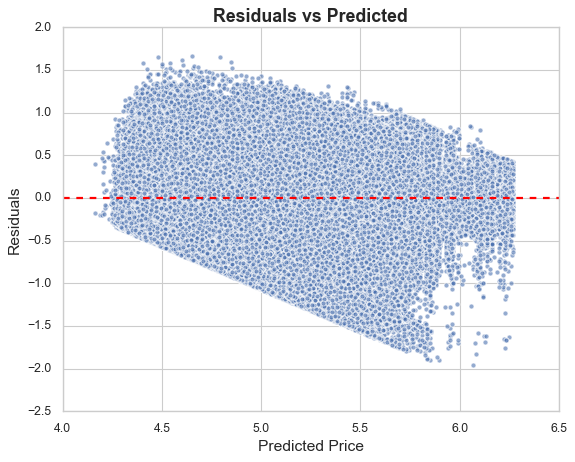

In [51]:
xgblog_residuals = y_test - xgblog_predictions

plt.figure(figsize=(8, 6))
plt.scatter(xgblog_predictions, xgblog_residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title('Residuals vs Predicted', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Price', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.show()

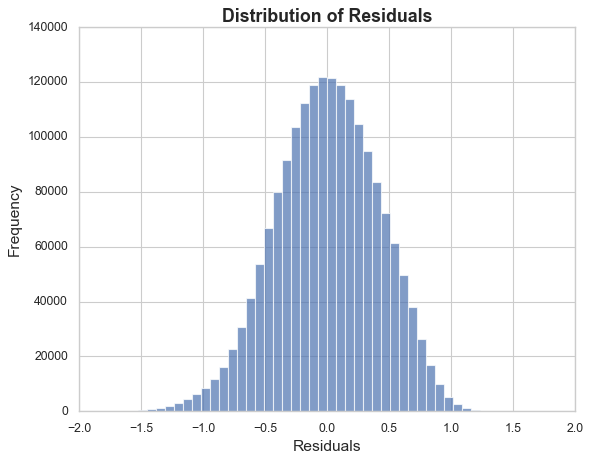

In [52]:
plt.figure(figsize=(8, 6))
plt.hist(xgblog_residuals, bins=50, alpha=0.7)
plt.title('Distribution of Residuals', fontsize=16, fontweight='bold')
plt.xlabel('Residuals', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

Text(0, 0.5, 'Importance')

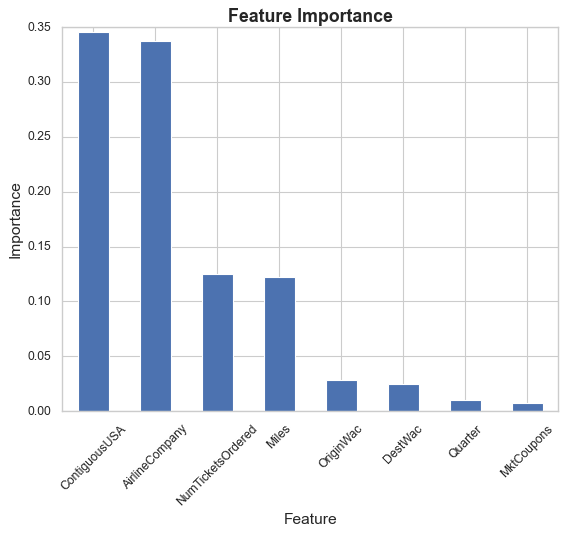

In [53]:
(pd.Series(xgblog_model.feature_importances_, index=X.columns)
 .sort_values(ascending=False)
   .plot(kind='bar'))
plt.title('Feature Importance', fontsize=16, fontweight='bold')
plt.xlabel('Feature', fontsize=14)
plt.xticks(rotation=45)
plt.ylabel('Importance', fontsize=14)

# SVR

In [68]:


t0 = time.time()

#sample from df
filtered_df_sample = filtered_df.sample(n=100000, random_state=42)

# prepe data
X = filtered_df_sample[['Miles', 'Quarter', 'OriginWac', 'DestWac', 'ContiguousUSA', 'AirlineCompany', 'NumTicketsOrdered', 'MktCoupons']]  # add/remove
X['AirlineCompany'] = OrdinalEncoder().fit_transform(X[['AirlineCompany']])

y = filtered_df_sample['LogPrice']
#traintestsplit
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# need to scale?
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# train
svrlog_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)  # linear kernel may be quick
svrlog_model.fit(X_train_scaled, y_train)

# predict
y_pred_svrlog = svrlog_model.predict(X_test_scaled)

# eval
mse_svrlog = mean_squared_error(y_test, y_pred_svr)
r2_svrlog = r2_score(y_test, y_pred_svrlog)
print(f"SVR MSE: {mse_svrlog}")
print(f"SVR R²: {r2_svrlog}")

t1 = time.time()
total_time = (t1-t0)/60
print('Code took', round(total_time, 2), 'minutes')

SVR MSE: 40710.52393621722
SVR R²: 0.23941538392486683
Code took 5.59 minutes


In [69]:
y_pred_original = np.exp(y_pred_svrlog)
y_test_original = np.exp(y_test)
rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
print("RMSE in dollars:", round(rmse_original, 2))

RMSE in dollars: 98.96


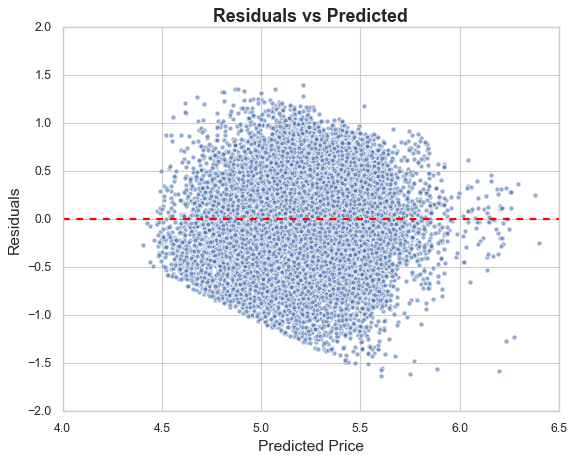

In [56]:
svrlog_residuals = y_test - y_pred_svrlog

plt.figure(figsize=(8, 6))
plt.scatter(y_pred_svrlog, svrlog_residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title('Residuals vs Predicted', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Price', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.show()

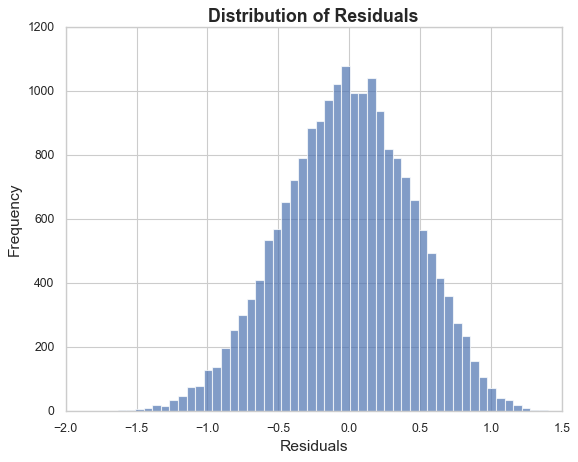

In [57]:
plt.figure(figsize=(8, 6))
plt.hist(svrlog_residuals, bins=50, alpha=0.7)
plt.title('Distribution of Residuals', fontsize=16, fontweight='bold')
plt.xlabel('Residuals', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

no feature importance with SVR

# Kmeans clustering with log/filtered data
## 4 clusters

In [58]:


t0 = time.time()

#select featyres
X = filtered_df[['Miles', 'Quarter', 'OriginWac', 'DestWac', 'ContiguousUSA',  'AirlineCompany', 'MktCoupons', 'NumTicketsOrdered']]
y = filtered_df['LogPrice']  # Ensure 'Price' aligns with filtered_df

# align x y
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)



X['AirlineCompany'] = OrdinalEncoder().fit_transform(X[['AirlineCompany']])

#can make more efficient:
#X[['Dest', 'Origin', 'AirlineCompany']] = OrdinalEncoder().fit_transform(X[['Dest', 'Origin', 'AirlineCompany']])

# k-means clustering- needc to test indivudal clusters for model
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
X['Cluster'] = kmeans.fit_predict(X)

#tts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train each cluster
kmlog_models = {}
for cluster in range(n_clusters):
    cluster_indices = X_train['Cluster'] == cluster
    X_cluster_train = X_train[cluster_indices].drop(columns=['Cluster'])
    y_cluster_train = y_train[cluster_indices]
    
    kmlog_model = XGBRegressor(
    n_estimators=100,    
    learning_rate=0.1,   
    max_depth=6,         
    subsample=0.8,       
    colsample_bytree=0.8, 
    random_state=42
)
    kmlog_model.fit(X_cluster_train, y_cluster_train)
    kmlog_models[cluster] = kmlog_model

# cluster prdict
X_test_clusters = X_test.copy()
X_test_clusters['Cluster'] = kmeans.predict(X_test_clusters.drop(columns=['Cluster']))
all_log_predictions = []  
for i in range(len(X_test)):
    cluster = X_test_clusters.iloc[i]['Cluster']
    kmlog_model = kmlog_models[cluster]
    kmlog_prediction = kmlog_model.predict([X_test_clusters.iloc[i].drop('Cluster')])  # Predict for the instance
    all_log_predictions.append(kmlog_prediction[0])

# spit out goodness
kmlog_mse = mean_squared_error(y_test, all_log_predictions)
print("Mean Squared Error:", )
print("Root mean Squared Error:", np.sqrt(kmlog_mse))

t1 = time.time()

total_time = (t1-t0)/60
print('Code took', round(total_time, 2), 'minutes')

Mean Squared Error:
Root mean Squared Error: 0.410649079855147
Code took 56.16 minutes


In [59]:
rmse_kmlog = np.sqrt(kmlog_mse)

# proption error
rmse_original_proportion_kmlog = np.exp(rmse_kmlog) - 1

# holla in the dolla
mean_price = df['PricePerTicket'].mean()
rmse_original_dollars_kmlog = mean_price * rmse_original_proportion_kmlog

print("Approximate RMSE in price prediction (dollars): $", round(rmse_original_dollars_kmlog, 2))

Approximate RMSE in price prediction (dollars): $ 118.04


# 10 clusters

In [60]:


t0 = time.time()

#select featyres
X = filtered_df[['Miles', 'Quarter', 'OriginWac', 'DestWac', 'ContiguousUSA',  'AirlineCompany', 'MktCoupons', 'NumTicketsOrdered']]
y = filtered_df['LogPrice']  # Ensure 'Price' aligns with filtered_df

# align x y
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)



X['AirlineCompany'] = OrdinalEncoder().fit_transform(X[['AirlineCompany']])

#can make more efficient:
#X[['Dest', 'Origin', 'AirlineCompany']] = OrdinalEncoder().fit_transform(X[['Dest', 'Origin', 'AirlineCompany']])

# k-means clustering- needc to test indivudal clusters for model
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
X['Cluster'] = kmeans.fit_predict(X)

#tts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train each cluster
kmlog_models = {}
for cluster in range(n_clusters):
    cluster_indices = X_train['Cluster'] == cluster
    X_cluster_train = X_train[cluster_indices].drop(columns=['Cluster'])
    y_cluster_train = y_train[cluster_indices]
    
    kmlog_model = XGBRegressor(
    n_estimators=100,    
    learning_rate=0.1,   
    max_depth=6,         
    subsample=0.8,       
    colsample_bytree=0.8, 
    random_state=42
)
    kmlog_model.fit(X_cluster_train, y_cluster_train)
    kmlog_models[cluster] = kmlog_model

# cluster prdict
X_test_clusters = X_test.copy()
X_test_clusters['Cluster'] = kmeans.predict(X_test_clusters.drop(columns=['Cluster']))
all_log_predictions = []  
for i in range(len(X_test)):
    cluster = X_test_clusters.iloc[i]['Cluster']
    kmlog_model = kmlog_models[cluster]
    kmlog_prediction = kmlog_model.predict([X_test_clusters.iloc[i].drop('Cluster')])  # Predict for the instance
    all_log_predictions.append(kmlog_prediction[0])

# spit out goodness
kmlog_mse = mean_squared_error(y_test, all_log_predictions)
print("Mean Squared Error:", )
print("Root mean Squared Error:", np.sqrt(kmlog_mse))

t1 = time.time()

total_time = (t1-t0)/60
print('Code took', round(total_time, 2), 'minutes')

Mean Squared Error:
Root mean Squared Error: 0.40725231483660407
Code took 55.52 minutes


In [61]:
rmse_kmlog = np.sqrt(kmlog_mse)

# proption error
rmse_original_proportion_kmlog = np.exp(rmse_kmlog) - 1

# holla in the dolla
mean_price = df['PricePerTicket'].mean()
rmse_original_dollars_kmlog = mean_price * rmse_original_proportion_kmlog

print("Approximate RMSE in price prediction (dollars): $", round(rmse_original_dollars_kmlog, 2))

Approximate RMSE in price prediction (dollars): $ 116.85


# 100 clusters

In [62]:


t0 = time.time()

#select featyres
X = filtered_df[['Miles', 'Quarter', 'OriginWac', 'DestWac', 'ContiguousUSA',  'AirlineCompany', 'MktCoupons', 'NumTicketsOrdered']]
y = filtered_df['LogPrice']  # Ensure 'Price' aligns with filtered_df

# align x y
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)



X['AirlineCompany'] = OrdinalEncoder().fit_transform(X[['AirlineCompany']])

#can make more efficient:
#X[['Dest', 'Origin', 'AirlineCompany']] = OrdinalEncoder().fit_transform(X[['Dest', 'Origin', 'AirlineCompany']])

# k-means clustering- needc to test indivudal clusters for model
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
X['Cluster'] = kmeans.fit_predict(X)

#tts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train each cluster
kmlog100_models = {}
for cluster in range(n_clusters):
    cluster_indices = X_train['Cluster'] == cluster
    X_cluster_train = X_train[cluster_indices].drop(columns=['Cluster'])
    y_cluster_train = y_train[cluster_indices]
    
    kmlog100_model = XGBRegressor(
    n_estimators=100,    
    learning_rate=0.1,   
    max_depth=6,         
    subsample=0.8,       
    colsample_bytree=0.8, 
    random_state=42
)
    kmlog100_model.fit(X_cluster_train, y_cluster_train)
    kmlog100_models[cluster] = kmlog100_model

# cluster prdict
X_test_clusters = X_test.copy()
X_test_clusters['Cluster'] = kmeans.predict(X_test_clusters.drop(columns=['Cluster']))
all_log100_predictions = []  
for i in range(len(X_test)):
    cluster = X_test_clusters.iloc[i]['Cluster']
    kmlog100_model = kmlog100_models[cluster]
    kmlog100_prediction = kmlog100_model.predict([X_test_clusters.iloc[i].drop('Cluster')])  # Predict for the instance
    all_log100_predictions.append(kmlog_prediction[0])

# spit out goodness
kmlog100_mse = mean_squared_error(y_test, all_log100_predictions)
print("Mean Squared Error:", )
print("Root mean Squared Error:", np.sqrt(kmlog100_mse))

t1 = time.time()

total_time = (t1-t0)/60
print('Code took', round(total_time, 2), 'minutes')

Mean Squared Error:
Root mean Squared Error: 0.7232893950023479
Code took 55.43 minutes


In [74]:
rmse_kmlog100 = np.sqrt(kmlog100_mse)

# proption error
rmse_original_proportion_kmlog100 = np.exp(rmse_kmlog100) - 1

# holla in the dolla
mean_price = df['PricePerTicket'].mean()
rmse_original_dollars_kmlog100 = mean_price * rmse_original_proportion_kmlog100

print("Approximate RMSE in price prediction (dollars): $", round(rmse_original_dollars_kmlog100, 2))

Approximate RMSE in price prediction (dollars): $ 246.68


In [78]:
rmse_original_dollars_kmlog100, rmse_original_dollars_kmlog, rmse_original_dollars_svrlog, rmse_original_dollars_xgblog

(246.67616116127618,
 116.84857623772825,
 9.846259670558136e+89,
 119.78920879326954)

# Comparing RMSE of each mode 

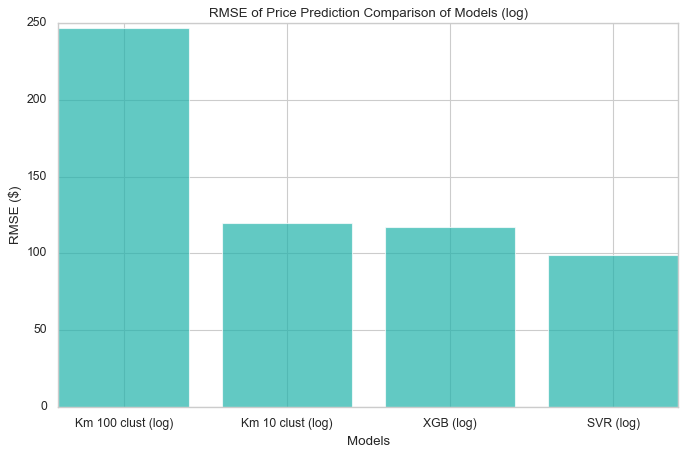

In [82]:
modelslog = pd.Series(['Km 100 clust (log)', 'Km 10 clust (log)', 'XGB (log)', 'SVR (log)'])
rmse_valueslog = pd.Series([rmse_original_dollars_kmlog100, rmse_original_dollars_kmlog, rmse_original, rmse_original_dollars_xgblog])

plt.figure(figsize=(10, 6))
plt.bar(modelslog, rmse_valueslog.sort_values(ascending=False), color='lightseagreen', alpha=.7)
plt.title('RMSE of Price Prediction Comparison of Models (log)')
plt.xlabel('Models')
plt.ylabel('RMSE ($)')
plt.show()

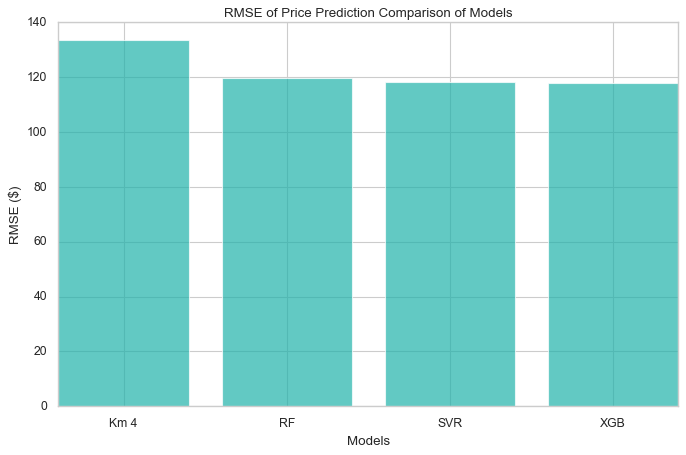

In [81]:
models = pd.Series(['Km 4', 'RF', 'SVR', 'XGB'])
#rmse_values = pd.Series([round(np.sqrt(km_mse), 2), round(np.sqrt(rf_mse), 2),  round(np.sqrt(mse_svr), 2), round(np.sqrt(xgb_mse), 2)])
rmse_values = pd.Series([118.19, 117.81,  round(np.sqrt(mse_svr), 2), round(np.sqrt(xgb_mse), 2)])

plt.figure(figsize=(10, 6))
plt.bar(models, rmse_values.sort_values(ascending=False), color='lightseagreen', alpha=.7)
plt.title('RMSE of Price Prediction Comparison of Models')
plt.xlabel('Models')
plt.ylabel('RMSE ($)')
plt.show()

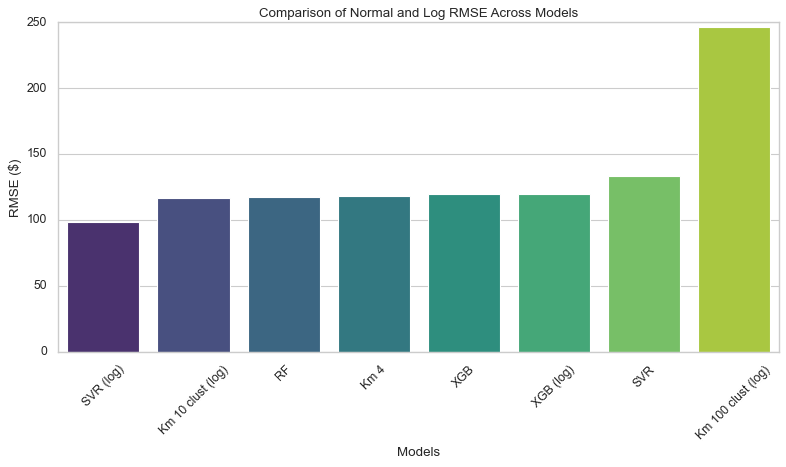

In [80]:
normal_rmse = pd.DataFrame({'Model': models, 'Normal_RMSE': rmse_values})
log_rmse = pd.DataFrame({'Model': modelslog, 'Log_RMSE': rmse_valueslog})

df_normal = normal_rmse.rename(columns={'Model': 'Model', 'Normal_RMSE': 'RMSE'})
df_log = log_rmse.rename(columns={'Model': 'Model', 'Log_RMSE': 'RMSE'})
allrmse_df = pd.concat([df_log, df_normal], ignore_index=True)
#sort for plot
allrmse_df = allrmse_df.sort_values(by='RMSE', ascending=True)

plt.figure(figsize=(10, 6))
sns.barplot(data=allrmse_df, x='Model', y='RMSE', palette='viridis', order=allrmse_df['Model'])


plt.title('Comparison of Normal and Log RMSE Across Models')
plt.xlabel('Models')
plt.xticks(rotation=45)
plt.ylabel('RMSE ($)')

plt.tight_layout()
plt.show()

# Conclusions
## 1) largest indicators in price is:
### 1)mileage
### 2) Company
## 2) Quarter is an unimportant predictor 
## 3 Need more idicators
### - it can be assumned including the date the ticket was purchased owuld be a strong indicator
## 4) Despite poor predictions, the computationally lightest model (XGboost) performs similarly to the best predictor, SVR, using log transformed price